In [46]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [48]:
data = []
labels = []

# Root directory (adjust path if you're not running notebook from ~/Desktop/GTSRB)
base_path = './Final_Training/Images'

for folder_name in sorted(os.listdir(base_path)):
    folder_path = os.path.join(base_path, folder_name)
    if not os.path.isdir(folder_path):
        continue

    csv_file = os.path.join(folder_path, f'GT-{folder_name}.csv')
    df = pd.read_csv(csv_file, sep=';')

    for _, row in df.iterrows():
        img_path = os.path.join(folder_path, row['Filename'])

        # Load and preprocess image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (32, 32))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Histogram equalization (optional but useful)
        image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
        image = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)

        data.append(image)
        labels.append(row['ClassId'])

X = np.array(data) / 255.0  # Normalize
y = np.array(labels)

print("Total images loaded:", X.shape[0])

Total images loaded: 39209


In [50]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [52]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

DEEP-CNN Model

In [55]:
def build_deep_cnn():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(43, activation='softmax'))

    return model

model = build_deep_cnn()
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

In [9]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.3824 - loss: 2.3804 - val_accuracy: 0.6234 - val_loss: 1.3233 - learning_rate: 0.0010
Epoch 2/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.8415 - loss: 0.4751 - val_accuracy: 0.9042 - val_loss: 0.2874 - learning_rate: 0.0010
Epoch 3/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9258 - loss: 0.2260 - val_accuracy: 0.9417 - val_loss: 0.1858 - learning_rate: 0.0010
Epoch 4/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9447 - loss: 0.1672 - val_accuracy: 0.9556 - val_loss: 0.1405 - learning_rate: 0.0010
Epoch 5/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9598 - loss: 0.1208 - val_accuracy: 0.9310 - val_loss: 0.2238 - learning_rate: 0.0010
Epoch 6/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.9621 - loss: 0.1136 - val_accuracy: 0.9467 - val_loss: 0.1637 - learning_rate: 0.0010
Epoch 7/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9676 - loss: 0.1029

In [10]:
 y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_val, y_pred_classes))
print(confusion_matrix(y_val, y_pred_classes))

246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       444
           2       1.00      1.00      1.00       450
           3       1.00      1.00      1.00       282
           4       1.00      1.00      1.00       396
           5       0.99      1.00      1.00       372
           6       0.99      1.00      0.99        84
           7       1.00      0.99      0.99       288
           8       1.00      1.00      1.00       282
           9       1.00      1.00      1.00       294
          10       1.00      1.00      1.00       402
          11       1.00      1.00      1.00       264
          12       1.00      1.00      1.00       420
          13       1.00      1.00      1.00       432
          14       1.00      1.00      1.00       156
          15       1.00      1.00      1.00       126
          16       1.00      1.00      1

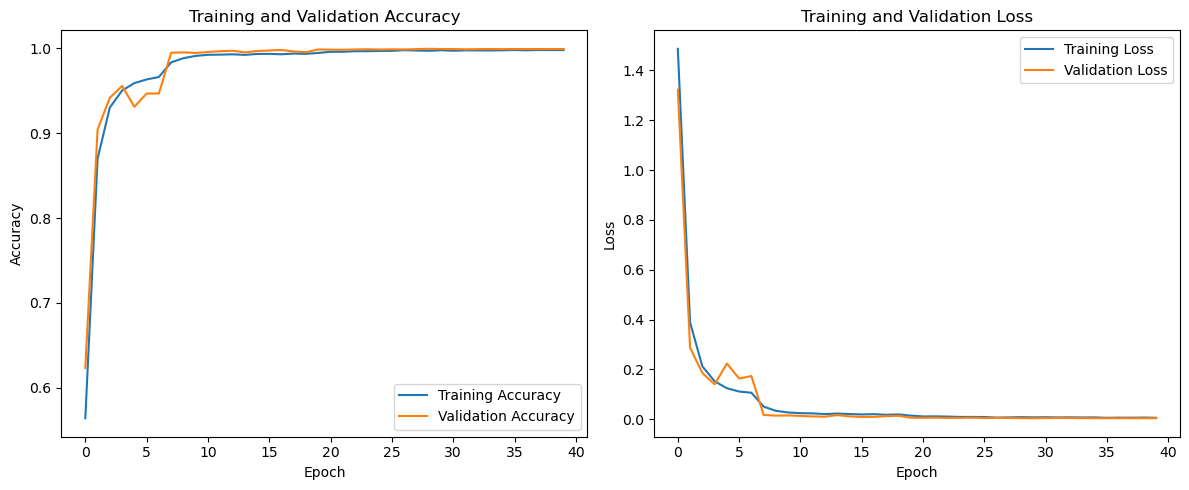

In [11]:

import matplotlib.pyplot as plt

# Assuming 'history' is the variable holding the training history returned by model.fit()
# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


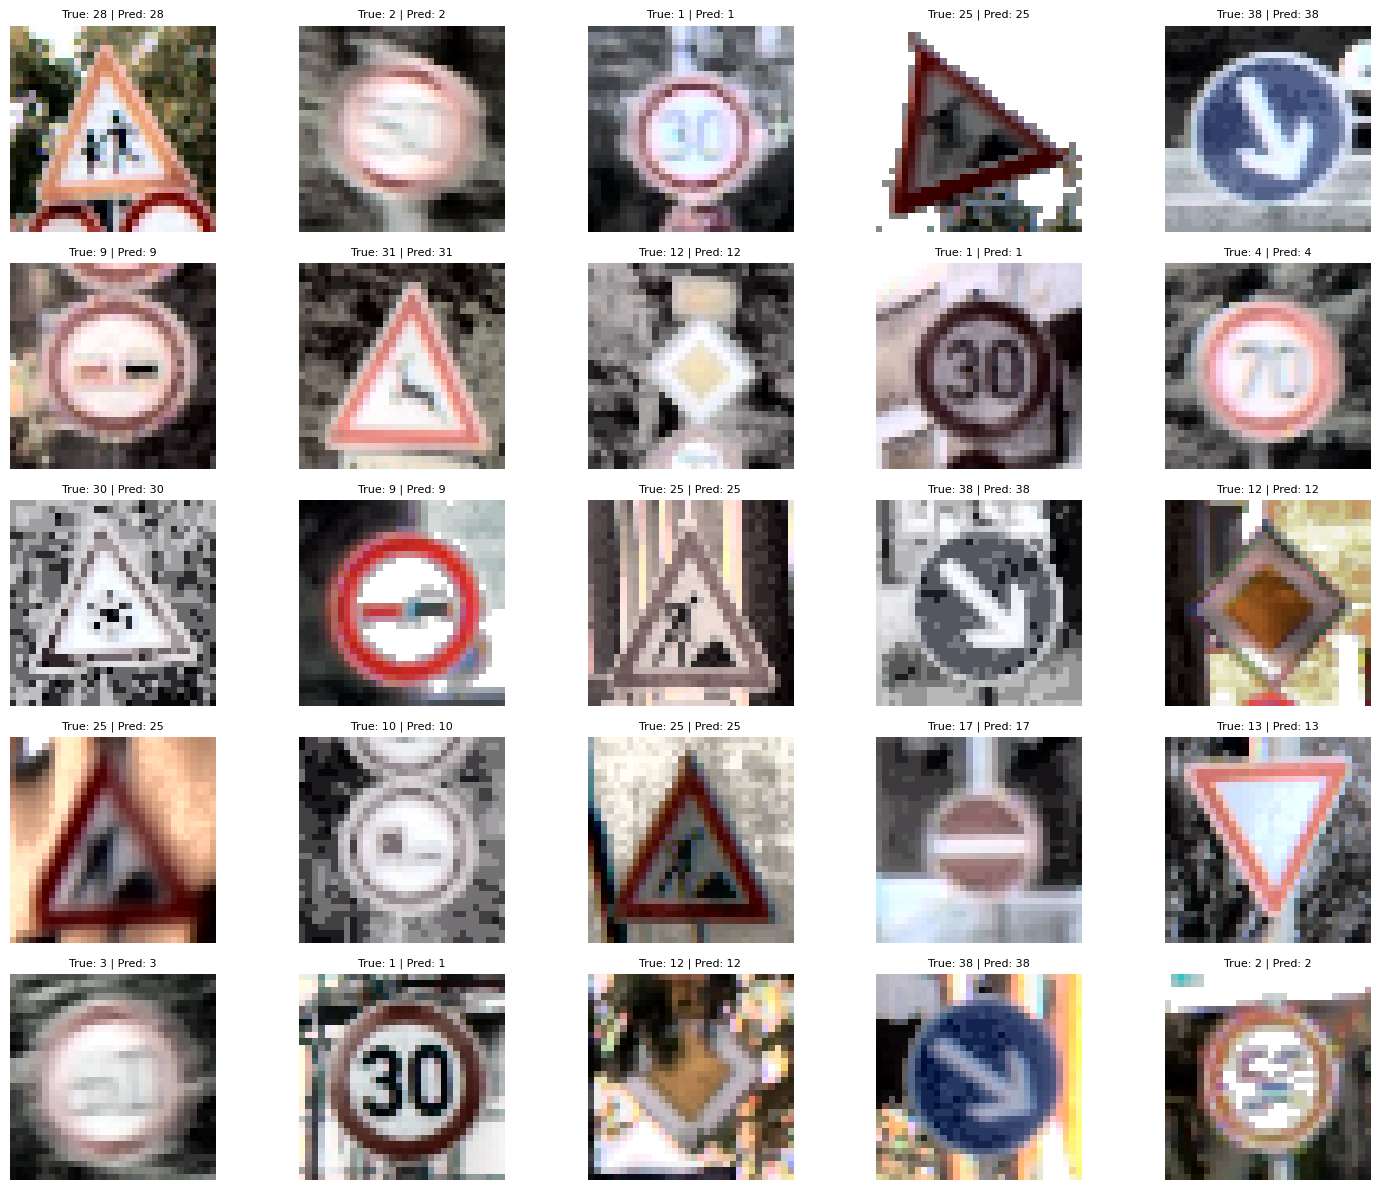

In [12]:
plt.figure(figsize=(15, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_val[i])
    plt.title(f"True: {y_val[i]} | Pred: {y_pred_classes[i]}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

SIMPLE-CNN-Model

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Total images loaded:", X.shape[0])


from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)
##
def build_simple_cnn():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(43, activation='softmax'))

    return model

model = build_simple_cnn()
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Total images loaded: 39209
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.2584 - loss: 2.7290 - val_accuracy: 0.7429 - val_loss: 0.8127 - learning_rate: 0.0010
Epoch 2/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6299 - loss: 1.1520 - val_accuracy: 0.8499 - val_loss: 0.4664 - learning_rate: 0.0010
Epoch 3/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.7169 - loss: 0.8674 - val_accuracy: 0.8888 - val_loss: 0.3825 - learning_rate: 0.0010
Epoch 4/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7719 - loss: 0.7095 - val_accuracy: 0.9339 - val_loss: 0.2324 - learning_rate: 0.0010
Epoch 5/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8090 - loss: 0.5926 - val_accuracy: 0.9481 - val_loss: 0.1966 - learning_rate: 0.0010
Epoch 6/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8351 - loss: 0.5133 - val_accuracy: 0.9620 - val_loss: 0.1516 - learning_rate: 0.0010
Epoch 7/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8551 - loss: 0.4591 - val_

In [15]:
 y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_val, y_pred_classes))
print(confusion_matrix(y_val, y_pred_classes))

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       444
           2       1.00      0.99      1.00       450
           3       1.00      1.00      1.00       282
           4       0.99      1.00      0.99       396
           5       0.99      0.97      0.98       372
           6       0.99      1.00      0.99        84
           7       0.98      0.99      0.98       288
           8       0.98      0.99      0.99       282
           9       1.00      1.00      1.00       294
          10       1.00      1.00      1.00       402
          11       1.00      1.00      1.00       264
          12       1.00      1.00      1.00       420
          13       1.00      1.00      1.00       432
          14       1.00      1.00      1.00       156
          15       0.99      1.00      1.00       126
          16       1.00      1.00      1

LeNet-Model

In [17]:
def build_lenet5():
    model = Sequential()
    
    model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 3), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(43, activation='softmax'))  # 43 classes for GTSRB

    return model

model = build_lenet5()
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3),
    ModelCheckpoint('best_model.keras.keras', save_best_only=True)
]

In [19]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.2111 - loss: 2.9113 - val_accuracy: 0.6455 - val_loss: 1.1028 - learning_rate: 0.0010
Epoch 2/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5619 - loss: 1.3762 - val_accuracy: 0.7539 - val_loss: 0.7056 - learning_rate: 0.0010
Epoch 3/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6827 - loss: 0.9926 - val_accuracy: 0.8513 - val_loss: 0.4755 - learning_rate: 0.0010
Epoch 4/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7542 - loss: 0.7692 - val_accuracy: 0.8768 - val_loss: 0.3848 - learning_rate: 0.0010
Epoch 5/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7965 - loss: 0.6334 - val_accuracy: 0.8732 - val_loss: 0.3425 - learning_rate: 0.0010
Epoch 6/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8233 - loss: 0.5496 - val_accuracy: 0.9147 - val_loss: 0.2616 - learning_rate: 0.0010
Epoch 7/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8509 - loss: 0.4750 - val_

In [20]:
 y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_val, y_pred_classes))
print(confusion_matrix(y_val, y_pred_classes))

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        42
           1       0.99      0.97      0.98       444
           2       0.97      0.96      0.96       450
           3       0.97      0.96      0.96       282
           4       0.96      0.99      0.98       396
           5       0.92      0.91      0.92       372
           6       1.00      1.00      1.00        84
           7       0.93      0.91      0.92       288
           8       0.95      0.97      0.96       282
           9       1.00      1.00      1.00       294
          10       1.00      1.00      1.00       402
          11       0.99      1.00      1.00       264
          12       1.00      1.00      1.00       420
          13       1.00      1.00      1.00       432
          14       1.00      1.00      1.00       156
          15       0.98      1.00      0.99       126
          16       1.00      1.00      1

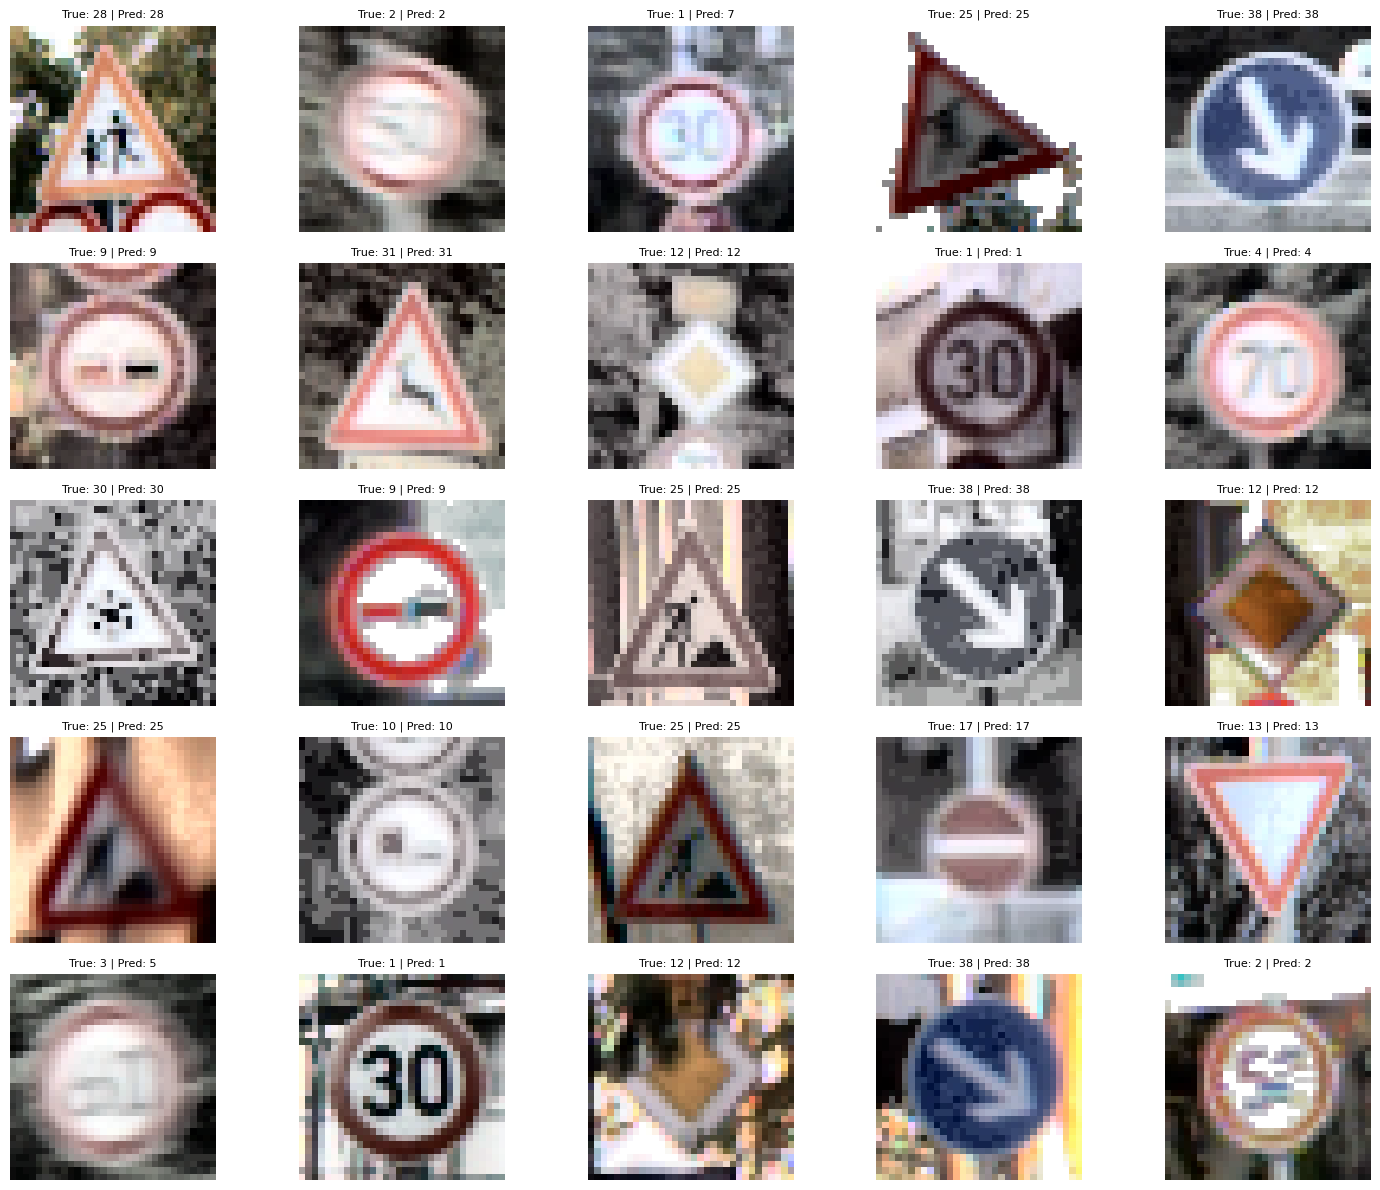

In [21]:
plt.figure(figsize=(15, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_val[i])
    plt.title(f"True: {y_val[i]} | Pred: {y_pred_classes[i]}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

MobileNetV2-Model

In [23]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

def build_mobilenetv2():
    base_model = MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze base layers for faster training

    inputs = Input(shape=(32, 32, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(43, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = build_mobilenetv2()
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/var/folders/28/g1cg9rnn7f5f5jk_39vbmj9h0000gn/T/ipykernel_41316/275130274.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights='imagenet')


In [24]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.1120 - loss: 3.4892 - val_accuracy: 0.1651 - val_loss: 3.1696 - learning_rate: 0.0010
Epoch 2/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.1773 - loss: 3.0821 - val_accuracy: 0.1858 - val_loss: 3.0126 - learning_rate: 0.0010
Epoch 3/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.1925 - loss: 2.9633 - val_accuracy: 0.1994 - val_loss: 2.9262 - learning_rate: 0.0010
Epoch 4/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.2061 - loss: 2.8655 - val_accuracy: 0.2020 - val_loss: 2.8722 - learning_rate: 0.0010
Epoch 5/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.2046 - loss: 2.8338 - val_accuracy: 0.2065 - val_loss: 2.8359 - learning_rate: 0.0010
Epoch 6/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.2064 - loss: 2.8116 - val_accuracy: 0.2082 - val_loss: 2.8090 - learning_rate: 0.0010
Epoch 7/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.2069 - loss: 2.7991

In [25]:
 y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_val, y_pred_classes))
print(confusion_matrix(y_val, y_pred_classes))

246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.18      0.32      0.23       444
           2       0.20      0.26      0.23       450
           3       0.24      0.04      0.06       282
           4       0.27      0.28      0.27       396
           5       0.31      0.20      0.24       372
           6       0.32      0.21      0.26        84
           7       0.23      0.02      0.04       288
           8       0.34      0.16      0.22       282
           9       0.35      0.17      0.23       294
          10       0.11      0.67      0.19       402
          11       0.34      0.22      0.26       264
          12       0.32      0.40      0.35       420
          13       0.36      0.54      0.43       432
          14       0.51      0.25      0.34       156
          15       0.63      0.13      0.22       126
          16       0.00      0.00      0

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
